# Emotion Classification from Speech

## 1. Setup and Imports

First, we'll import all the necessary libraries for our project. This includes libraries for data manipulation (`pandas`, `numpy`), audio processing (`librosa`), machine learning (`tensorflow`, `scikit-learn`), and plotting (`matplotlib`, `seaborn`).

In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow messages

import warnings
warnings.filterwarnings('ignore')  # Suppress Python warnings

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TF logs in notebook

# Rest of your imports
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib



E0000 00:00:1750783289.034577    5023 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750783289.100465    5023 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750783289.454517    5023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750783289.454570    5023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750783289.454576    5023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750783289.454582    5023 computation_placer.cc:177] computation placer already registered. Please check linka

In [17]:

np.random.seed(42)
tf.random.set_seed(42)

DATA_PATH = '../data'
MODEL_PATH = '../models'
os.makedirs(MODEL_PATH, exist_ok=True)


In [19]:
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

def parse_filename(filename):
    parts = filename.replace('.wav', '').split('-')
    if len(parts) >= 7:
        return {
            'filename': filename,
            'emotion_code': parts[2],
            'emotion': emotion_map.get(parts[2], 'unknown'),
            'intensity': parts[3],
            'statement': parts[4],
            'repetition': parts[5],
            'actor': parts[6]
        }
    return None


In [25]:
def extract_features(file_path, max_length=3):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=22050, duration=max_length)
        audio = np.pad(audio, (0, sr * max_length - len(audio)), 'constant') if len(audio) < sr * max_length else audio[:sr * max_length]

        # Feature extraction
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
        centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(audio)
        rms = librosa.feature.rms(y=audio)

        # Ensure all are 1D arrays before concatenation
        features = np.concatenate([
            np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
            np.mean(chroma, axis=1), np.std(chroma, axis=1),
            np.mean(mel[:20], axis=1), np.std(mel[:20], axis=1),  # mel is usually large, limit to first 20
            np.mean(contrast, axis=1), np.std(contrast, axis=1),
            np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1),
            [np.mean(centroid)], [np.mean(rolloff)], [np.mean(zcr)], [np.mean(rms)]
        ])

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [26]:
audio_files = []
for actor_dir in os.listdir(DATA_PATH):
    if actor_dir.startswith('Actor_'):
        for file in os.listdir(os.path.join(DATA_PATH, actor_dir)):
            if file.endswith('.wav'):
                metadata = parse_filename(file)
                if metadata:
                    metadata['filepath'] = os.path.join(DATA_PATH, actor_dir, file)
                    audio_files.append(metadata)

df = pd.DataFrame(audio_files)
print(df['emotion'].value_counts())


emotion
happy        192
disgust      192
calm         192
fearful      192
angry        192
sad          192
surprised    192
neutral       96
Name: count, dtype: int64


In [27]:
from tqdm import tqdm
features_list = []
valid_indices = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row['filepath'])
    if features is not None:
        features_list.append(features)
        valid_indices.append(idx)

df_filtered = df.iloc[valid_indices].reset_index(drop=True)
features_array = np.array(features_list)


100%|██████████| 1440/1440 [06:28<00:00,  3.71it/s]


In [29]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_filtered['emotion'])

X_train, X_temp, y_train, y_temp = train_test_split(
    features_array, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [30]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [31]:
model = create_model((X_train_scaled.shape[1],), len(label_encoder.classes_))

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(f'{MODEL_PATH}/final_emotion_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=200,
                    batch_size=16,
                    callbacks=callbacks)


Epoch 1/200
55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1612 - loss: 2.7664

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1638 - loss: 2.7473 - val_accuracy: 0.2824 - val_loss: 1.8806 - learning_rate: 0.0010
Epoch 2/200
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2372 - loss: 2.1186

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2383 - loss: 2.1155 - val_accuracy: 0.3704 - val_loss: 1.6797 - learning_rate: 0.0010
Epoch 3/200
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3485 - loss: 1.8201

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3481 - loss: 1.8201 - val_accuracy: 0.4444 - val_loss: 1.5196 - learning_rate: 0.0010
Epoch 4/200
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3617 - loss: 1.7229

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3622 - loss: 1.7212 - val_accuracy: 0.4676 - val_loss: 1.4544 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4212 - loss: 1.5558 - val_accuracy: 0.4676 - val_loss: 1.4005 - learning_rate: 0.0010
Epoch 6/200
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4859 - loss: 1.4451

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4863 - loss: 1.4444 - val_accuracy: 0.5046 - val_loss: 1.3837 - learning_rate: 0.0010
Epoch 7/200
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4931 - loss: 1.3508

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4943 - loss: 1.3476 - val_accuracy: 0.5278 - val_loss: 1.3094 - learning_rate: 0.0010
Epoch 8/200
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5323 - loss: 1.2752

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5322 - loss: 1.2754 - val_accuracy: 0.5324 - val_loss: 1.2790 - learning_rate: 0.0010
Epoch 9/200
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5695 - loss: 1.2005

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5699 - loss: 1.2004 - val_accuracy: 0.5509 - val_loss: 1.3267 - learning_rate: 0.0010
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5829 - loss: 1.1829 - val_accuracy: 0.5231 - val_loss: 1.2706 - learning_rate: 0.0010
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6246 - loss: 1.0738 - val_accuracy: 0.5370 - val_loss: 1.2471 - learning_rate: 0.0010
Epoch 12/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6173 - loss: 1.0416 - val_accuracy: 0.5463 - val_loss: 1.1994 - learning_rate: 0.0010
Epoch 13/200
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6337 - loss: 1.0060

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6334 - loss: 1.0052 - val_accuracy: 0.5602 - val_loss: 1.1414 - learning_rate: 0.0010
Epoch 14/200
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6809 - loss: 0.8995

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6793 - loss: 0.8995 - val_accuracy: 0.5694 - val_loss: 1.1448 - learning_rate: 0.0010
Epoch 15/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6891 - loss: 0.8646 - val_accuracy: 0.5648 - val_loss: 1.1463 - learning_rate: 0.0010
Epoch 16/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7406 - loss: 0.7785 - val_accuracy: 0.5694 - val_loss: 1.1100 - learning_rate: 0.0010
Epoch 17/200
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7810 - loss: 0.6909

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7783 - loss: 0.6963 - val_accuracy: 0.5787 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 18/200
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7223 - loss: 0.7266

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7238 - loss: 0.7259 - val_accuracy: 0.5926 - val_loss: 1.1416 - learning_rate: 0.0010
Epoch 19/200
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7727 - loss: 0.6392

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7726 - loss: 0.6416 - val_accuracy: 0.6019 - val_loss: 1.1085 - learning_rate: 0.0010
Epoch 20/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7991 - loss: 0.6133 - val_accuracy: 0.5648 - val_loss: 1.1324 - learning_rate: 0.0010
Epoch 21/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7957 - loss: 0.5617 - val_accuracy: 0.5602 - val_loss: 1.1871 - learning_rate: 0.0010
Epoch 22/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7795 - loss: 0.6331 - val_accuracy: 0.5926 - val_loss: 1.2075 - learning_rate: 0.0010
Epoch 23/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8324 - loss: 0.4989 - val_accuracy: 0.5926 - val_loss: 1.1777 - learning_rate: 0.0010
Epoch 24/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8472 - loss: 0.4564 - val_accuracy: 0.6019 - val_loss: 1.1847 - learning_rate: 0.0010
Epoch 25/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8245 - loss: 0.4882 - val_accuracy:

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8405 - loss: 0.4249 - val_accuracy: 0.6111 - val_loss: 1.2795 - learning_rate: 5.0000e-04
Epoch 29/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8666 - loss: 0.3977 - val_accuracy: 0.6065 - val_loss: 1.2870 - learning_rate: 5.0000e-04
Epoch 30/200
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8909 - loss: 0.3331

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8911 - loss: 0.3324 - val_accuracy: 0.6389 - val_loss: 1.1945 - learning_rate: 5.0000e-04
Epoch 31/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8838 - loss: 0.3372 - val_accuracy: 0.6296 - val_loss: 1.2067 - learning_rate: 5.0000e-04
Epoch 32/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9249 - loss: 0.2625 - val_accuracy: 0.6019 - val_loss: 1.2348 - learning_rate: 5.0000e-04
Epoch 33/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9185 - loss: 0.2536 - val_accuracy: 0.6019 - val_loss: 1.2619 - learning_rate: 5.0000e-04
Epoch 34/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9274 - loss: 0.2588 - val_accuracy: 0.6157 - val_loss: 1.2803 - learning_rate: 5.0000e-04
Epoch 35/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9029 - loss: 0.2732 - val_accuracy: 0.6065 - val_loss: 1.2714 - learning_rate: 5.0000e-04
Epoch 36/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9335 - los

In [32]:
best_model = tf.keras.models.load_model(f'{MODEL_PATH}/final_emotion_model.h5')
y_pred = best_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("F1 Macro:", f1_score(y_test, y_pred_classes, average='macro'))
print("F1 Weighted:", f1_score(y_test, y_pred_classes, average='weighted'))

print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy: 0.6342592592592593
F1 Macro: 0.6197829068812412
F1 Weighted: 0.6343796205222758

Classification Report:
               precision    recall  f1-score   support

       angry       0.78      0.75      0.76        28
        calm       0.74      0.69      0.71        29
     disgust       0.67      0.69      0.68        29
     fearful       0.82      0.62      0.71        29
       happy       0.52      0.59      0.55        29
     neutral       0.38      0.43      0.40        14
         sad       0.52      0.41      0.46        29
   surprised       0.61      0.79      0.69        29

    accuracy                           0.63       216
   macro avg       0.63      0.62      0.62       216
weighted avg       0.64      0.63      0.63       216



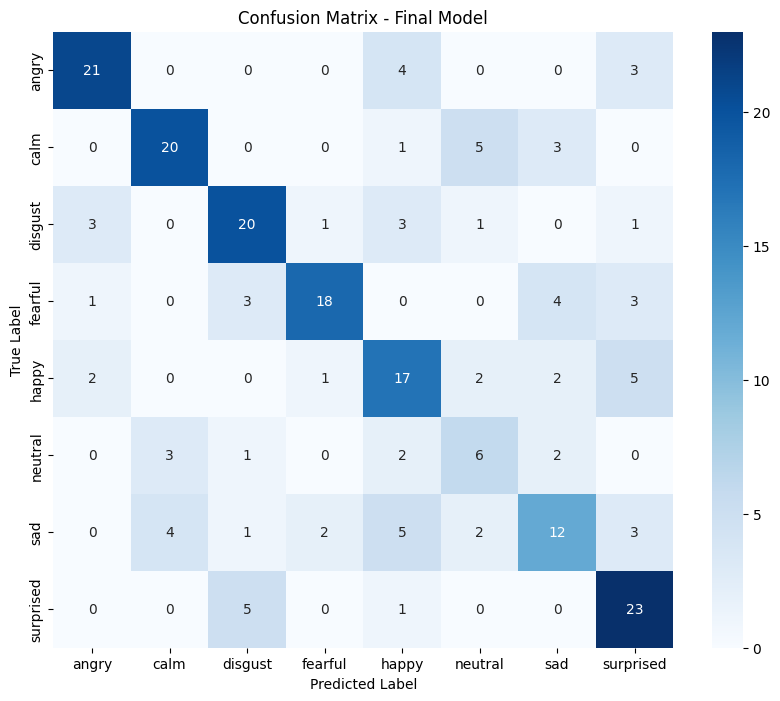

In [33]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [34]:
best_model.save(f'{MODEL_PATH}/final_emotion_classifier_model.h5')
joblib.dump(scaler, f'{MODEL_PATH}/final_scaler.pkl')
joblib.dump(label_encoder, f'{MODEL_PATH}/final_label_encoder.pkl')


['../models/final_label_encoder.pkl']

In [35]:
def predict_emotion(audio_path):
    model = tf.keras.models.load_model(f'{MODEL_PATH}/final_emotion_classifier_model.h5')
    scaler = joblib.load(f'{MODEL_PATH}/final_scaler.pkl')
    encoder = joblib.load(f'{MODEL_PATH}/final_label_encoder.pkl')
    
    features = extract_features(audio_path)
    if features is None:
        return "Invalid audio file"
    
    scaled = scaler.transform(features.reshape(1, -1))
    probs = model.predict(scaled)[0]
    pred = encoder.inverse_transform([np.argmax(probs)])[0]
    
    return pred, probs

sample_path = df_filtered.iloc[0]['filepath']
emotion, prob = predict_emotion(sample_path)
print(f"Predicted: {emotion}")
print(f"Confidence: {np.max(prob):.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted: happy
Confidence: 0.99
